In [1]:
import keras
import numpy as np
import os
from imutils import paths
import random
import cv2
from sklearn.model_selection import train_test_split
import keras.models     
from keras.layers import Activation, Dense, Flatten, Dropout
from keras.layers.pooling import MaxPooling2D
from keras.layers.convolutional import Conv2D
import pandas as pd
from keras.models import Sequential
from skimage.filters import prewitt_h

from matplotlib import pyplot
from PIL import Image
from numpy import asarray
from mtcnn.mtcnn import MTCNN

Using TensorFlow backend.


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

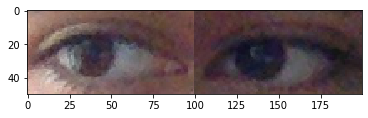

In [2]:
detector = MTCNN()
def extract_face(filename, required_size=(224, 224)):
    global detector
    # load image from file
    pixels = pyplot.imread(filename)
    # create the detector, using default weights
#     detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    try:
        left_eye_x, left_eye_y  = results[0]['keypoints']['left_eye']
        right_eye_x, right_eye_y  = results[0]['keypoints']['right_eye']
    except IndexError:
        print ("FACE NOT FOUND")
        return None

    left_eye_image = pixels[left_eye_y-25:left_eye_y+25, left_eye_x-50:left_eye_x+50]
    right_eye_image = pixels[right_eye_y-25:right_eye_y+25, right_eye_x-50:right_eye_x+50]
    eyes_img = cv2.hconcat([left_eye_image, right_eye_image])
    # resize pixels to the model size
    image = Image.fromarray(eyes_img)
    face_array = asarray(image)
    return face_array

training_data = []
validation_data = []
data = []
labels = []

imagePaths = sorted(list(paths.list_images('../')))
random.seed(42)
random.shuffle(imagePaths)

x = 25
y = 60
h = 50
w = 200


def get_image(imagePath):
    print(".", end="")
    image = extract_face(imagePath)
    pyplot.imshow(image)
    label = imagePath.split(os.path.sep)[-1].split('-')[1:3]
    return (image, ([label[0]+label[1]]))


mp = np.array(list(map(get_image, imagePaths)))
data = mp[:,0]
labels = mp[:,1]

# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data,
    labels, test_size=0.25, random_state=42)



In [26]:


def data_genereator(data,labels, batch_size):
        num_rows = int(len(data))
        # Initialize a counter
        counter = 0
        while True:
            for content, label in zip(data, labels):

                content = np.array(content)
                ct = content.reshape(1,h,w,3)
                #manual onehot
                onehot = [0,0,0,0,0,0]
                if label[0] == 0:
                    continue

                onehot[int(label[0][1])*3 + int(label[0][0])] = 1
                onehot = np.array(onehot).reshape(1,6)

                counter = counter + 1
                if(counter%batch_size == 0):
                    yield ct, onehot



model = Sequential()

#__________________________________________________________
model.add(Conv2D(200,(3,3),input_shape=(h,w, 3)))
# model.add(Flatten())
model.add(Activation('relu')) #Activation 1
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.10))

model.add(Conv2D(100,(3,3)))
model.add(Activation('relu')) #Activation 2
model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.10))

model.add(Conv2D(64,(3,3)))
model.add(Activation('relu')) #Activation 3 # was relu
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(32, activation='relu')) #128
model.add(Dropout(0.35))
model.add(Dense(6, activation="softmax"))
# model.add(Activation('sigmoid')) #Activation 5
#__________________________________________________________
# from keras.layers import BatchNormalization
# model = Sequential()
# model.add(Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(h, w, 1)))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(BatchNormalization())
# model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(BatchNormalization())
# model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(BatchNormalization())
# model.add(Conv2D(96, kernel_size=(3,3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(BatchNormalization())
# model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# #model.add(Dropout(0.3))
# model.add(Dense(6, activation = 'softmax'))


# from keras.optimizers import SGD
# opt = SGD(lr=0.05)#, momentum=0.9)
model.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy'])


training_generator = data_genereator(trainX,trainY, batch_size=1)
validation_generator = data_genereator(testX,testY, batch_size=1)
model.fit_generator(training_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=10,
                   epochs=200,
                   validation_steps=2
                   )
model.save('models/simple_CNN.h5')


# img = image.load_img('test/imagename.jpg', target_size=(1280,720))
# prediction = model.predict(img)
# print(prediction)

Epoch 1/200
10/10 [==============================] - 1s 85ms/step - loss: 70.5388 - accuracy: 0.2000 - val_loss: 0.0916 - val_accuracy: 0.5000
Epoch 2/200
10/10 [==============================] - 1s 59ms/step - loss: 7.8572 - accuracy: 0.1000 - val_loss: 2.9045 - val_accuracy: 0.0000e+00
Epoch 3/200
10/10 [==============================] - 1s 53ms/step - loss: 3.2394 - accuracy: 0.2000 - val_loss: 0.8306 - val_accuracy: 0.5000
Epoch 4/200
10/10 [==============================] - 1s 58ms/step - loss: 2.9859 - accuracy: 0.1000 - val_loss: 1.4878 - val_accuracy: 1.0000
Epoch 5/200
10/10 [==============================] - 1s 59ms/step - loss: 1.9372 - accuracy: 0.1000 - val_loss: 1.7917 - val_accuracy: 0.0000e+00
Epoch 6/200
10/10 [==============================] - 1s 54ms/step - loss: 3.4379 - accuracy: 0.1000 - val_loss: 0.6330 - val_accuracy: 0.5000
Epoch 7/200
10/10 [==============================] - 1s 54ms/step - loss: 6.6066 - accuracy: 0.1000 - val_loss: 1.8811 - val_accuracy: 0.00

10/10 [==============================] - 1s 51ms/step - loss: 1.1587 - accuracy: 0.5000 - val_loss: 0.1152 - val_accuracy: 0.5000
Epoch 58/200
10/10 [==============================] - 1s 52ms/step - loss: 2.1078 - accuracy: 0.4000 - val_loss: 1.2341 - val_accuracy: 1.0000
Epoch 59/200
10/10 [==============================] - 1s 51ms/step - loss: 1.1384 - accuracy: 0.9000 - val_loss: 0.2152 - val_accuracy: 1.0000
Epoch 60/200
10/10 [==============================] - 1s 54ms/step - loss: 1.4604 - accuracy: 0.6000 - val_loss: 1.0456 - val_accuracy: 1.0000
Epoch 61/200
10/10 [==============================] - 1s 52ms/step - loss: 1.1225 - accuracy: 0.6000 - val_loss: 0.9448 - val_accuracy: 1.0000
Epoch 62/200
10/10 [==============================] - 1s 51ms/step - loss: 1.0131 - accuracy: 0.7000 - val_loss: 1.0273 - val_accuracy: 1.0000
Epoch 63/200
10/10 [==============================] - 1s 54ms/step - loss: 1.5368 - accuracy: 0.6000 - val_loss: 0.6563 - val_accuracy: 0.5000
Epoch 64/200

Epoch 114/200
10/10 [==============================] - 1s 66ms/step - loss: 0.0166 - accuracy: 1.0000 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 115/200
10/10 [==============================] - 1s 68ms/step - loss: 0.1496 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 116/200
10/10 [==============================] - 1s 62ms/step - loss: 1.6395 - accuracy: 0.7000 - val_loss: 0.0098 - val_accuracy: 1.0000
Epoch 117/200
10/10 [==============================] - 1s 63ms/step - loss: 0.2994 - accuracy: 0.9000 - val_loss: 0.0065 - val_accuracy: 1.0000
Epoch 118/200
10/10 [==============================] - 1s 57ms/step - loss: 0.7317 - accuracy: 0.7000 - val_loss: 0.0411 - val_accuracy: 1.0000
Epoch 119/200
10/10 [==============================] - 1s 56ms/step - loss: 0.0554 - accuracy: 1.0000 - val_loss: 0.0279 - val_accuracy: 1.0000
Epoch 120/200
10/10 [==============================] - 1s 58ms/step - loss: 0.4222 - accuracy: 0.8000 - val_loss: 0.0311 - val_accur

Epoch 170/200
10/10 [==============================] - 1s 58ms/step - loss: 0.0680 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 171/200
10/10 [==============================] - 1s 59ms/step - loss: 1.2609 - accuracy: 0.9000 - val_loss: 2.2683e-04 - val_accuracy: 1.0000
Epoch 172/200
10/10 [==============================] - 1s 57ms/step - loss: 0.0257 - accuracy: 1.0000 - val_loss: 5.2224e-04 - val_accuracy: 1.0000
Epoch 173/200
10/10 [==============================] - 1s 58ms/step - loss: 0.0194 - accuracy: 1.0000 - val_loss: 3.4207e-04 - val_accuracy: 1.0000
Epoch 174/200
10/10 [==============================] - 1s 64ms/step - loss: 0.0262 - accuracy: 1.0000 - val_loss: 1.3720e-04 - val_accuracy: 1.0000
Epoch 175/200
10/10 [==============================] - 1s 59ms/step - loss: 0.0052 - accuracy: 1.0000 - val_loss: 7.9629e-05 - val_accuracy: 1.0000
Epoch 176/200
10/10 [==============================] - 1s 58ms/step - loss: 1.0668 - accuracy: 0.8000 - val_loss

In [29]:
model.evaluate_generator(validation_generator, steps=6)

[0.019876234233379364, 1.0]

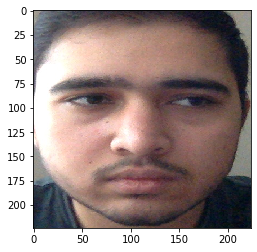

In [48]:
eyes_img = extract_face('../dataset/dataset-0-0/frame-0-0-10.jpg')
# img = cv2.imread('../dataset/dataset-0-0/frame-0-0-110.jpg')
# img = cv2.imread('../dataset/dataset-1-0/frame-1-0-110.jpg')
# img = cv2.imread('../dataset/dataset-2-0/frame-2-0-110.jpg')
# img = cv2.imread('../dataset/dataset-0-1/frame-0-1-110.jpg')
# img = cv2.imread('../dataset/dataset-1-1/frame-1-1-110.jpg')
# img = cv2.imread('../dataset/dataset-2-1/frame-2-1-10.jpg')
pyplot.imshow(eyes_img)
# im = img.reshape(1,h,w,3)


In [31]:
# from matplotlib import pyplot
# from PIL import Image
# from numpy import asarray
# from mtcnn.mtcnn import MTCNN
# # extract a single face from a given photograph
# def extract_face(filename, required_size=(224, 224)):
#     # load image from file
#     pixels = pyplot.imread(filename)
#     # create the detector, using default weights
#     detector = MTCNN()
#     # detect faces in the image
#     results = detector.detect_faces(pixels)
#     # extract the bounding box from the first face
#     x1, y1, width, height = results[0]['box']
#     x2, y2 = x1 + width, y1 + height
#     # extract the face
#     face = pixels[y1:y2, x1:x2]
#     # resize pixels to the model size
#     image = Image.fromarray(face)
#     image = image.resize(required_size)
#     face_array = asarray(image)
#     return face_array

# # load the photo and extract the face
# pixels = extract_face('../dataset/dataset-1-0/frame-1-0-110.jpg')
# # plot the extracted face
# pyplot.imshow(pixels)
# # show the plot
# pyplot.show()